In [1]:
# Usual imports
import os
import sys
import time
import datetime
import json
import csv
import glob
import pprint
import importlib
from tqdm import tqdm
from collections import Counter

import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, style
from matplotlib.ticker import FixedLocator
from matplotlib.dates import DateFormatter

import seaborn as sns
from IPython.display import Image
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

# For regression
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Custom modules
sys.path.insert(0, '../')
import psychometry
import parser
import utils

# Some edits to matplotlib
# https://towardsdatascience.com/simple-ways-to-improve-your-matplotlib-b64eebccfd5
# https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08
plt.rcParams.update({'font.size': 15})
style.use('seaborn-paper') #sets the size of the charts
style.use('ggplot')

bg_color = (0.96862745, 0.96862745, 0.96862745)
d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

In [2]:
parser = importlib.reload(parser)
utils = importlib.reload(utils)

# Some constants
data_folder = '../data/ema-responses'
rubriks_folder = '../data/ema-rubriks'
geocoder_cache_name = '../data/geocoder_cache.json'
psychometry_vars = ['qids', 'camsr', 'ipip']

no_numeric_vars = ['gender', 'healthcare_speciality', 'healthcare_job']

# Create a new data dictionary
db = dict()

data_files = glob.glob('%s/*.tsv'%data_folder)

# Create a JSON file to store geocoder cache
if os.path.exists(geocoder_cache_name):
    geocoder_cache = json.load(open(geocoder_cache_name, 'rb'))
else:
    print('Initiating geocoder cache')
    geocoder_cache = dict()

for data_file in tqdm(data_files):
    panel_name = os.path.split(data_file)[1].replace('.tsv', '')
    
    with open('%s/%s.json'%(rubriks_folder, panel_name), 'rb') as f:
        rubrik = json.load(f)
    
    data_raw = utils.loadtsv(data_file)
    data_dict = utils.convert2numeric(data_raw, rubrik, no_numeric_vars)
    
    # Create a new participant ID if needed
    for idx in range(len(data_dict['ID'])):
        if data_dict['ID'][idx] not in db:
            db[data_dict['ID'][idx]] = parser.new_participant(data_dict['ID'][idx])
        else:
            pass
        
    # Now load data into the db
    if 'S' in panel_name:
        for psycho_var in psychometry_vars:
            if '%s1'%psycho_var in data_dict:
                data_dict = utils.process_psychometry(data_dict, psycho_var)
        
            for key in data_dict:
                for idx in range(len(data_dict['ID'])):
                    if key == 'ID':
                        pass
                    elif key == 'timestamp':
                        db[data_dict['ID'][idx]]['reg_time'] = data_dict['timestamp'][idx]
                    elif key == 'qids':
                        db[data_dict['ID'][idx]]['QIDS'][data_dict['timestamp'][idx]] = data_dict['qids'][idx]
                    elif key == 'location':
                        location = json.loads(data_dict['location'][idx])
                        db[data_dict['ID'][idx]]['location'] = location
                        #state, geocoder_cache = parser.get_state(location, geocoder_cache)
                        #db[data_dict['ID'][idx]]['state'] = state 
                        pass
                    else:
                        db[data_dict['ID'][idx]][key] = data_dict[key][idx]
                
    elif 'A' in panel_name:
        # Only QIDS is processed
        if 'qids1' in data_dict:
            data_dict = utils.process_psychometry(data_dict, 'qids')
            
            for idx in range(len(data_dict['ID'])):
                db[data_dict['ID'][idx]]['QIDS'][data_dict['timestamp'][idx]] = data_dict['qids'][idx]
        
        for idx in range(len(data_dict['ID'])):
            info = {key:data_dict[key][idx] for key in data_dict}
            db[data_dict['ID'][idx]]['A'].append(info)
                                                     
    elif 'K' in panel_name:
        for idx in range(len(data_dict['ID'])):
            info = {key:data_dict[key][idx] for key in data_dict}
            burnout_risk, burnout_protective = utils.process_burnout(info)
            info = {'burnout_risk': burnout_risk, 'burnout_protective': burnout_protective, 'timestamp': info['timestamp']}
            db[data_dict['ID'][idx]]['K'].append(info)
            
# First, store the cache
with open(geocoder_cache_name, 'w') as write_file:
    json.dump(geocoder_cache, write_file)

100%|██████████| 77/77 [00:07<00:00, 10.85it/s]


In [3]:
week_freq =  2
epoch1 = 24*3600*(datetime.datetime(2020, 4, 1, 0, 0).timestamp()//(24*3600))*1000
epoch2 = 24*3600*(datetime.datetime(2020, 9, 14, 0, 0).timestamp()//(24*3600))*1000

const = 24*3600*1000*7*week_freq
week_bins = np.arange(epoch1, epoch2 + const, const)
nweeks = len(week_bins)

v1 = [key for key in db if db[key]['healthcare_worker'] and\
     (('City' in db[key]['location'] and 'Houston' in db[key]['location']['City']) or\
      ('State' in db[key]['location'] and 'TX' in db[key]['location']['State']))]
v2 = [key for key in db if db[key]['healthcare_worker'] and\
      'ipip' in db[key]]
print(len(v2))

valid_ids = [key for key in db if db[key]['healthcare_worker'] and\
             len(db[key]['QIDS']) > 0 and\
             len(db[key]['K']) > 0 and\
             len(db[key]['A']) > 0 and\
             'camsr' in db[key] and\
             'ipip' in db[key] and\
             ('City' in db[key]['location'] and\
             'Houston' in db[key]['location']['City']) or\
             ('State' in db[key]['location'] and\
              'TX' in db[key]['location']['State'])]

rdb = {key:db[key] for key in valid_ids}

rdict = dict()

for idx in range(nweeks):
    rdict['qids%d'%(idx+1)] = []
    rdict['mood%d'%(idx+1)] = []
    
rdict['qids'] = []
rdict['mood'] = []
rdict['camsr'] = []
rdict['neuroticism'] = []
rdict['pre_physical'] = []
rdict['pre_mental'] = []
rdict['extra_compensation'] = []
rdict['job_change'] = []
rdict['redeployed'] = []
rdict['risk_exposure'] = []
rdict['workload'] = []
rdict['substance'] = []

for key in valid_ids:
    try:
        K_panel = rdb[key]['K'][-1]
    except IndexError:
        pprint.pprint(rdb[key])
        print(len(rdb[key]['K']) > 0)
        break
    
    #if 'hippocratic_adhering' not in K_panel or\
    #   'essential_covid19' not in K_panel or\
    #   'essential_typical' not in K_panel:
    #    continue
        
    qids_arr = rdb[key]['QIDS']
    
    for idx in range(nweeks):
        rdict['qids%d'%(idx+1)].append(float('Nan'))
        rdict['mood%d'%(idx+1)].append(float('Nan'))
        
    for ts, qids_val in qids_arr.items():
        timeval = (ts*1000 - epoch1)//const + 1
        rdict['qids%d'%timeval][-1] = qids_val
        
    for A_panel in rdb[key]['A']:
        timeval = (A_panel['timestamp']*1000 - epoch1)//const + 1
        rdict['mood%d'%timeval][-1] = A_panel['mood']
        
    rdict['qids'].append(list(rdb[key]['QIDS'].values())[0])
    rdict['mood'].append(rdb[key]['A'][-1]['mood'])
    rdict['substance'].append(rdb[key]['A'][-1]['substance'])
    rdict['camsr'].append(rdb[key]['camsr'])
    rdict['neuroticism'].append(rdb[key]['ipip'][4])
    rdict['pre_physical'].append(len(rdb[key]['pre_physical']))
    rdict['pre_mental'].append(len(rdb[key]['pre_mental']))
    
    rdict['extra_compensation'].append(rdb[key]['healthcare_extra_compensation'])
    rdict['job_change'].append(rdb[key]['healthcare_job_change'])
    rdict['redeployed'].append(rdb[key]['healthcare_redeployed'])
    rdict['risk_exposure'].append(rdb[key]['healthcare_risk_exposure'])
    rdict['workload'].append(rdb[key]['healthcare_workload`'])
    
    for key2 in K_panel:
        if 'away_from_work' in key2 or 'timestamp' in key2 or 'note' in key2 or 'ID' in key2:
            pass
        else:
            try:
                rdict[key2].append(K_panel[key2])
            except KeyError:
                rdict[key2] = []
                rdict[key2].append(K_panel[key2])
    
rpd = pd.DataFrame.from_dict(rdict)

209
{'A': [{'ID': 294,
        'aches': 0,
        'breathing': 0,
        'cough': 0,
        'fever': 98,
        'gastro': ['Diarrhea', 'Nausea'],
        'health_worry': 1,
        'mood': 2,
        'nose': 0,
        'situation': ['Sheltered-in-place'],
        'smell': 0,
        'status': 0,
        'symptoms': ['Gastrointestinal symptoms'],
        'throat': 0,
        'timestamp': 1586835959.0},
       {'ID': 294,
        'aches': 0,
        'anxious': 1,
        'attitude': ['COVID-19 is my biggest worry these days',
                     'Making decisions is harder'],
        'behavior_others': ['I am wearing a mask on regular basis',
                            'My behavior towards other humans has changed'],
        'breathing': 0,
        'city_management': ['Mostly lacking and negligent'],
        'city_status': 0,
        'cough': 0,
        'covid_concerns': ['Because it has become a predominant issue on my '
                           'workplace/city'],
        'covid

In [4]:
utils = importlib.reload(utils)

locations = [db[key]['location']['City'] for key in db if 'City' in db[key]['location']]
print(locations)

['San Antonio', 'Dallas', 'Dallas', '27519', 'Scro', 'Alb', 'Houston', 'Lantana', 'Prairieville', 'Bellaire', 'pittsburgh', 'Cypress', 'Longmont', 'Houston', 'East ', 'Arcadia', 'Azle', 'Houston', 'San ramon', 'Fulshear', 'New Delhi', 'Gilbert', 'Santa Barbara', 'Smithville', 'Austin ', 'Austin', 'Austin', '', 'Houston', 'Houston', 'Montreal', 'Mon', 'Houston', '', 'Minneapolis ', 'New York', 'Houston', 'Vallejo', 'Houston', 'Jersey Village', 'Houston', 'Houston', 'unincorporated suburb', 'Houston', 'Houston', 'Sugar Land', 'Sea', 'Ballwin', 'Richmond ', 'Houston', 'Stafford ', 'Houston', 'Houston', 'Houst', 'Goleta', 'Forney', 'Cypress', 'Houston ', 'pearland', 'Houst', 'Lubbock', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Whitehouse', 'Cary', 'Houston', 'Houston ', 'Fuquay-Varina', 'Allen', 'Dallas', 'The Woodlands ', 'Dallas', '', 'Sy', '', 'Singapore ', '', 'Chennai', '', 'Zouk mosbeh', 'Bei', '', 'Doha', '', 'Bchamoun', 'Se', 'Mountain Home', 'New Orleans', 'Charlesto

In [5]:
rpd['qids'] = rpd['qids'] / 27 
rpd['camsr'] = rpd['camsr'] / 48
rpd['pre_physical'] = rpd['pre_physical'] / 5
rpd['pre_mental'] = rpd['pre_mental'] / 5

# Normalize burnout scores too
rpd['burnout_risk'] = rpd['burnout_risk'] / (1.0*max(rpd['burnout_risk']))
rpd['burnout_protective'] = rpd['burnout_protective'] / (1.0*max(rpd['burnout_protective']))

KeyError: 'burnout_risk'

In [88]:

#varnames = ['qids', 'camsr',  'pre_physical', 'pre_mental', 
#            'purpose', 'ppe_borrow', 'restricted_resources','sacrificed', 'hippocratic_adhering',
#            'reasonable_policies','job_change']
varnames = ['qids', 'camsr', 'pre_physical', 'pre_mental', 'job_change', 'burnout_risk', 'burnout_protective']
dep_varname = 'mood'

def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook
import tqdm

#Initialization variables
Y = rpd[dep_varname]
X = rpd[varnames]
k = 11
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []
coeff_list = []

#Looping over k = 1 to k = 11 features in X
for k in tqdm.notebook.tnrange(1,len(X.columns) + 1, desc = 'Loop...'):
    #coeff_list.append([])
    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        est = sm.GLS(endog=Y, exog=X[list(combo)], missing='drop')
        est2 = est.fit()
        #print(est2.mse_total)
        RSS_list.append(est2.ssr)                  #Append lists
        R_squared_list.append(est2.rsquared_adj)
        feature_list.append(combo)
        coeff_list.append(np.array(est2.params))
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list,'coefficients':coeff_list})

df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(50))
display(df_max.head(50))

df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

,numb_features,RSS,R_squared,features,coefficients
6,1,62.748841,0.873773,"(burnout_protective,)",[3.5278490701967664]
17,2,58.138714,0.881160,"(camsr, burnout_protective)","[1.8607854007930635, 2.1458297301789186]"
46,3,55.839427,0.883989,"(camsr, pre_physical, burnout_protective)","[2.363570087792861, -2.432285402577924, 2.4831..."
66,4,55.497569,0.882777,"(qids, camsr, pre_physical, burnout_protective)","[-0.35557744663860147, 2.327918374981717, -1.9..."
102,5,55.263521,0.881293,"(qids, camsr, pre_physical, job_change, burnou...","[-0.33923896984161406, 2.1831919903668577, -2...."
122,6,55.247110,0.879283,"(qids, camsr, pre_physical, job_change, burnou...","[-0.4003796904651751, 2.095394615558429, -2.01..."
126,7,55.245956,0.877167,"(qids, camsr, pre_physical, pre_mental, job_ch...","[-0.4127435741071537, 2.0883036033438405, -2.0..."


,numb_features,RSS,R_squared,features,coefficients
6,1,62.748841,0.873773,"(burnout_protective,)",[3.5278490701967664]
17,2,58.138714,0.881160,"(camsr, burnout_protective)","[1.8607854007930635, 2.1458297301789186]"
46,3,55.839427,0.883989,"(camsr, pre_physical, burnout_protective)","[2.363570087792861, -2.432285402577924, 2.4831..."
66,4,55.497569,0.882777,"(qids, camsr, pre_physical, burnout_protective)","[-0.35557744663860147, 2.327918374981717, -1.9..."
102,5,55.263521,0.881293,"(qids, camsr, pre_physical, job_change, burnou...","[-0.33923896984161406, 2.1831919903668577, -2...."
122,6,55.247110,0.879283,"(qids, camsr, pre_physical, job_change, burnou...","[-0.4003796904651751, 2.095394615558429, -2.01..."
126,7,55.245956,0.877167,"(qids, camsr, pre_physical, pre_mental, job_ch...","[-0.4127435741071537, 2.0883036033438405, -2.0..."


,numb_features,RSS,R_squared,features,coefficients,min_RSS,max_R_squared
0,1,241.612405,0.513965,"(qids,)",[5.1908504069604255],62.748841,0.873773
1,1,68.545916,0.862111,"(camsr,)",[4.566215347612433],62.748841,0.873773
2,1,128.436782,0.741633,"(pre_physical,)",[10.40229885057471],62.748841,0.873773
3,1,205.427711,0.586756,"(pre_mental,)",[6.71686746987952],62.748841,0.873773
4,1,291.666667,0.413275,"(job_change,)",[2.666666666666666],62.748841,0.873773


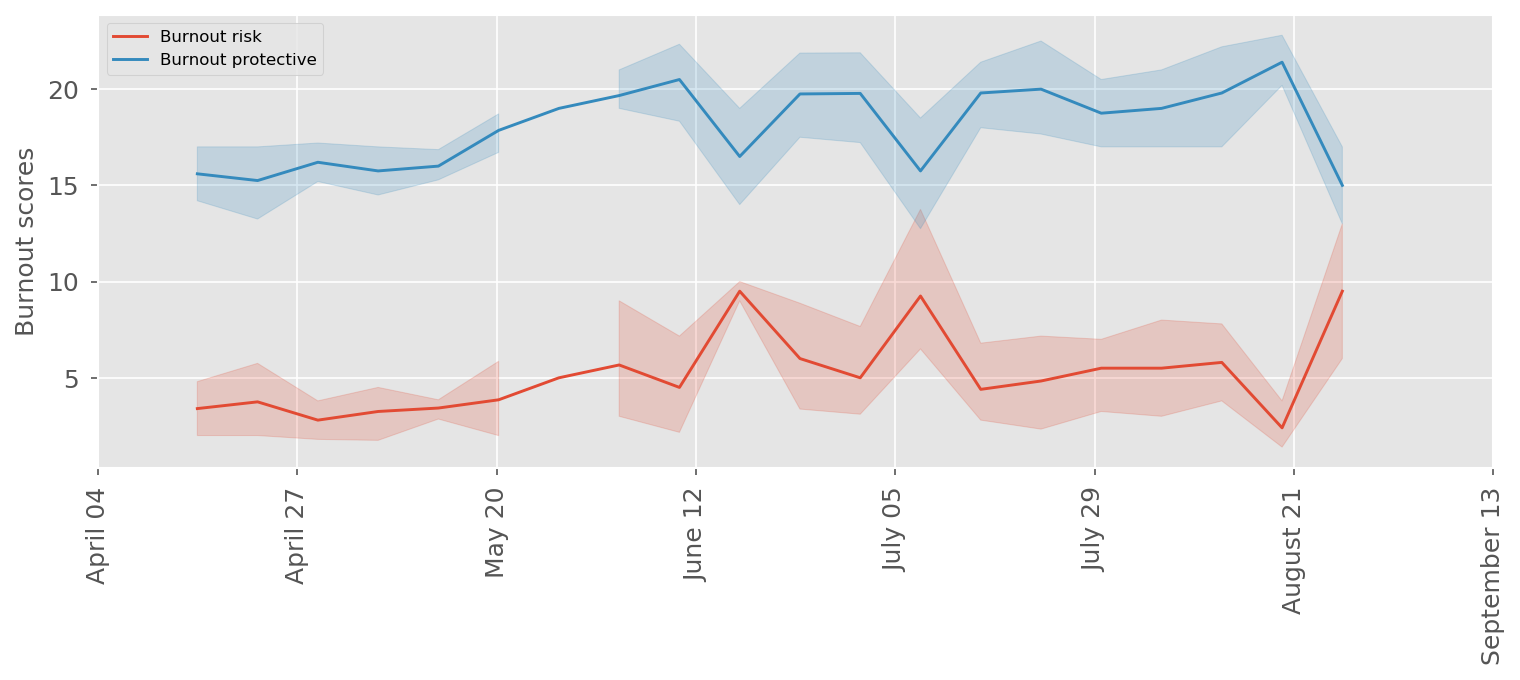

In [94]:
# Analyze burnout ids
burnout_ids = [key for key in db if len(db[key]['K']) > 0 and db[key]['gender'] == 'male']

burnout_dict = {'risk':[], 'protective': [], 'timestamp': []}

const = 3600*24*7

for key in burnout_ids:
    K_panels = db[key]['K']
    
    for K_panel in K_panels:
        burnout_dict['risk'].append(K_panel['burnout_risk'])
        burnout_dict['protective'].append(K_panel['burnout_protective'])
        burnout_dict['timestamp'].append(const*(K_panel['timestamp'] // const))
        
burnout_pd = pd.DataFrame.from_dict(burnout_dict)

fig = plt.figure(dpi=150, figsize=[12, 4])
sns.lineplot(x='timestamp', y='risk', data=burnout_pd, label='Burnout risk')
sns.lineplot(x='timestamp', y='protective', data=burnout_pd, label='Burnout protective')
plt.xlabel('')
plt.ylabel('Burnout scores')

timestamps, _ = plt.xticks()

plt.xticks(timestamps, labels=[d2s(timestamp*1000) for timestamp in timestamps], rotation='vertical', fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [86]:
# Now let us do Delta QIDS around a lockdown lifting date -- May 26th
tx_ids = [key for key in db if 'state' in db[key] and db[key]['state'] == 'TX']

len(tx_ids)

0